# HW2 - ex 1

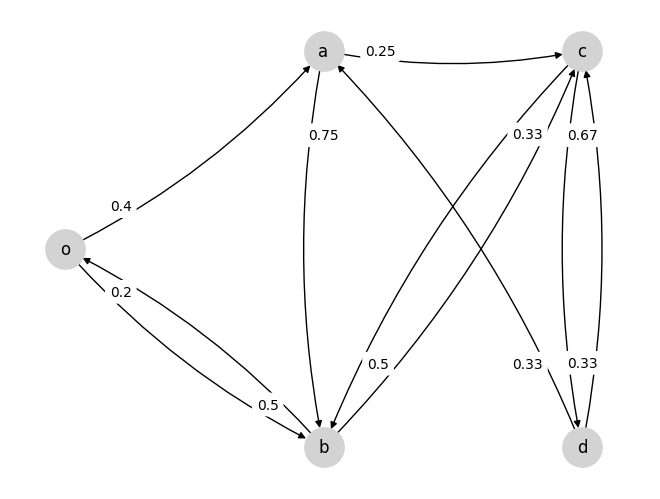

In [1]:
import networkx as nx
import numpy as np
from itertools import groupby
from numpy.random import choice,random
import matplotlib.pyplot as plt
%matplotlib inline
import sys

np.random.seed(seed=42)
np.set_printoptions(precision=3, suppress= True)

Λ = np.array([
    [0,   2/5, 1/5, 0,   0  ],
    [0,   0,   3/4, 1/4, 0  ],
    [1/2, 0,   0,   1/3, 0  ],
    [0,   0,   1/3, 0,   2/3],
    [0,   1/3, 0,   1/3, 0  ],
])
nodes = ['o', 'a', 'b', 'c', 'd']
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from([('o', 'a', float("{0:.2f}".format(2/5))), ('o', 'b', float("{0:.2f}".format(1/5))), 
                           ('a', 'b', float("{0:.2f}".format(3/4))), ('a', 'c', float("{0:.2f}".format(1/4))), 
                           ('b', 'o', float("{0:.2f}".format(1/2))), ('b', 'c', float("{0:.2f}".format(1/2))), 
                           ('c', 'b', float("{0:.2f}".format(1/3))), ('c', 'd', float("{0:.2f}".format(2/3))), 
                           ('d', 'a', float("{0:.2f}".format(1/3))), ('d', 'c', float("{0:.2f}".format(1/3)))])
pos={'o':(0,0),'a':(1,2),'b':(1,-2),'c':(2,2),'d':(2,-2)}
nx.draw(G, pos=pos, with_labels=True, node_size = 800, font_size=12, node_color='lightgray',  connectionstyle='arc3, rad = 0.1')
labels = {e: G.edges[e]['weight'] for e in G.edges}
val = nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.20, rotate = False, horizontalalignment ='center')

In [2]:
n = len(G.nodes)

ω = np.sum(Λ, axis=1)
ω_star = np.max(ω)

D = np.diag(ω)
P = np.linalg.inv(D) @ Λ
P_cum = np.cumsum(P, axis=1)

P_bar = Λ/ω_star
P_bar = P_bar + np.diag(np.ones(len(ω)) - np.sum(P_bar, axis=1))
P_bar_cum = np.cumsum(P_bar, axis = 1)

print("Number of nodes: ", n)
print("\Vector ω:\n", ω)
print("\nMatrix D:\n", D)
print("\nMatrix P:\n", P)
#print("\nMatrix P_cum:\n", P_cum)
print("\nMatrix P_bar:\n", P_bar)
#print("\nMatrix Q_cum:\n", Q_cum)

Number of nodes:  5
\Vector ω:
 [0.6   1.    0.833 1.    0.667]

Matrix D:
 [[0.6   0.    0.    0.    0.   ]
 [0.    1.    0.    0.    0.   ]
 [0.    0.    0.833 0.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.667]]

Matrix P:
 [[0.    0.667 0.333 0.    0.   ]
 [0.    0.    0.75  0.25  0.   ]
 [0.6   0.    0.    0.4   0.   ]
 [0.    0.    0.333 0.    0.667]
 [0.    0.5   0.    0.5   0.   ]]

Matrix P_bar:
 [[0.4   0.4   0.2   0.    0.   ]
 [0.    0.    0.75  0.25  0.   ]
 [0.5   0.    0.167 0.333 0.   ]
 [0.    0.    0.333 0.    0.667]
 [0.    0.333 0.    0.333 0.333]]


<>:15: SyntaxWarning: invalid escape sequence '\V'
<>:15: SyntaxWarning: invalid escape sequence '\V'
/var/folders/kx/6jwj_rhn4r3b_8_dlptcy_000000gn/T/ipykernel_78754/3248483263.py:15: SyntaxWarning: invalid escape sequence '\V'
  print("\Vector ω:\n", ω)


In [3]:
def simulate_ctmc(start_node, max_steps=10000, target_return_node=None, target_hit_node=None):
    """
    Simulate CTMC with rate matrix Lambda
    Returns: (path, return_time, hit_time)
    """
    current = start_node
    time = 0.0
    path = [(time, current)]
    ω = Λ.sum(axis=1)  # Sum rows for total exit rates
    return_time = None
    hit_time = None
    left_start = False  # Track if left starting node (for return time)
    
    for step in range(max_steps):
        rate = ω[current]
        if rate == 0:
            break
        
        # Exponential waiting time: t ~ Exp(rate)
        u = np.random.rand()
        dt = -np.log(u) / rate if u > 0 else 0.0
        time += dt
        
        # Choose next node using normalized rates as probabilities
        probs = Λ[current, :] / rate  
        next_node = np.random.choice(n, p=probs)
        
        # NOTE : the next two implemented blocks will say to us if we are calculating return time or hitting time or both.
        #--------------------------------------------------------------------------------------------------------------
        # Return time calculation (must leave then return)
        if target_return_node is not None:
            if current == target_return_node and next_node != target_return_node:
                left_start = True  # Particle left starting node
            if left_start and next_node == target_return_node and return_time is None:
                return_time = time  # First return after leaving
                if target_hit_node is None:
                    break  # Stop if only measuring return time
        
        # Hitting time calculation (first arrival)
        if target_hit_node is not None and next_node == target_hit_node and hit_time is None:
            hit_time = time  # First hit to target
            if target_return_node is None:
                break  # Stop if only measuring hitting time
        #--------------------------------------------------------------------------------------------------------------
        
        current = next_node
        path.append((time, current))
        
        if step > max_steps-2:
            break
            
    return path, return_time, hit_time

In [4]:
## question a

n_sim = 1000
return_times = []
for _ in range(n_sim):
    _, ret_time, _ = simulate_ctmc(start_node=1, target_return_node=1, max_steps=1000)
    if ret_time is not None:
        return_times.append(ret_time)

avg_return_sim = np.mean(return_times)
print(f"a) Simulated average return time to node a: {avg_return_sim:.4f} s ")


a) Simulated average return time to node a: 6.6828 s 


In [5]:
return_times = []
for _ in range(n_sim):
    _, ret_time, _ = simulate_ctmc(start_node=1, target_return_node=1, max_steps=1000)
    if ret_time is not None:
        return_times.append(ret_time)

avg_return_sim = np.mean(return_times)
print(f"a) Simulated average return time to node a: {avg_return_sim:.4f} s ")


a) Simulated average return time to node a: 6.5760 s 


a) Simulated average return time to node a: 6.5760 s 


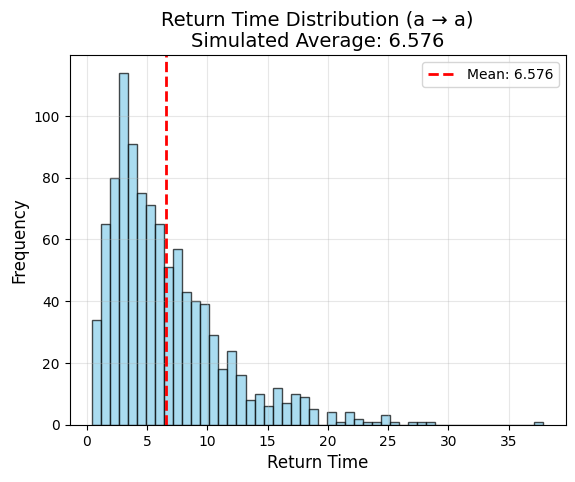

In [6]:

print(f"a) Simulated average return time to node a: {avg_return_sim:.4f} s ")

plt.hist(return_times, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(avg_return_sim, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_return_sim:.3f}')
plt.xlabel('Return Time', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Return Time Distribution (a → a)\nSimulated Average: {avg_return_sim:.3f}', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# question b

#stady distribution
Q = Λ - np.diag(Λ.sum(axis=1))
# πQ = 0, ∑π=1
A = Q.T
A = np.vstack([A, np.ones(n)])
b = np.zeros(n+1)
b[-1] = 1
pi = np.linalg.lstsq(A, b, rcond=None)[0]
print(f"Steady-state distribution π: {pi}")

rate_out = Λ.sum(axis=1)
E_return_theoretical = 1 / (pi[1] * rate_out[1]) if pi[1] > 0 else float('inf')
print(f"b) Theoretical E_a[T_a^+] = {E_return_theoretical:.4f} s")

Steady-state distribution π: [0.217 0.149 0.261 0.186 0.186]
b) Theoretical E_a[T_a^+] = 6.7083 s


c) Simulated average hitting time from o to d: 10.8327


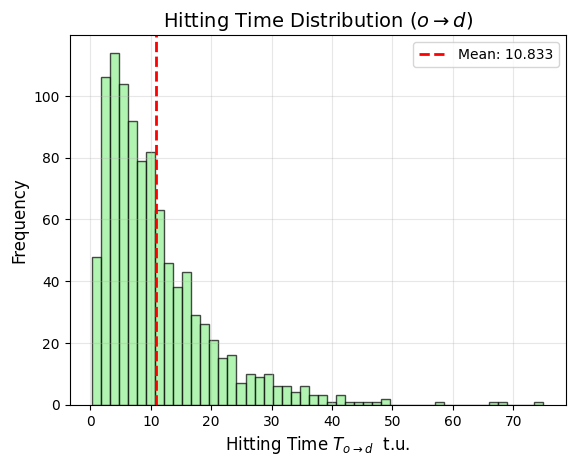

In [8]:
# question c

n_sim = 1000

hit_times = []
for c in range(n_sim):
    c, c, hit_time = simulate_ctmc(start_node=0, target_hit_node=4, max_steps=1000)
    if hit_time is not None:
        hit_times.append(hit_time)

avg_hit_sim = np.mean(hit_times)
print(f"c) Simulated average hitting time from o to d: {avg_hit_sim:.4f}")

plt.hist(hit_times, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(avg_hit_sim, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_hit_sim:.3f}')
plt.xlabel('Hitting Time $T_{o \\to d}$  t.u.', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Hitting Time Distribution $(o \\to d)$', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig('hitting_time_distribution.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [9]:
# question d

rate_out = Λ.sum(axis=1)
P = np.zeros((n, n))
for i in range(n):
    if rate_out[i] > 0:
        P[i, :] = Λ[i, :] / rate_out[i]
A = np.eye(n) - P
b = np.zeros(n)

for i in range(n):
    if i != 4:  # Exclude node d
        b[i] = 1 / rate_out[i] if rate_out[i] > 0 else 0
    else:
        A[i, :] = np.eye(n)[i, :]  # E_d = 0

E_hit = np.linalg.solve(A, b)
E_o_T_d = E_hit[0]  # node o
print(f"d) Theoretical E_o[T_d] = {E_hit[0]:.4f}")

d) Theoretical E_o[T_d] = 10.7667


The consensus state is: [0.315 0.315 0.315 0.315 0.315]
Invariant distribution π: [0.162 0.185 0.269 0.231 0.154]
The consensus value is: 0.3153846153846153


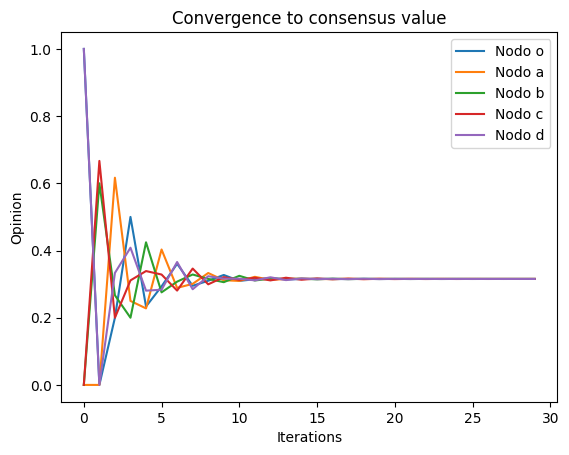

In [10]:
#question e

#number of iterations
steps = 30

# save the evolution of the consensus
x = np.zeros((n,steps))

# set initial condition (1,0,0,0,1)
x[:,0] = np.array([1,0,0,0,1])
# evolve the states
for t in range(1,steps):
    x[:,t] = P @ x[:,t-1]
    
print("The consensus state is:", x[:,steps-1])

values,vectors = np.linalg.eig(P.T)

# selects the eigenvalue 1 and print the eigenvector
for index in [i for i in range(n) if np.isclose(values[i],1)]: 
    pi = vectors[:,index].real  # -> eigenvectors are complex but pi is real, so we convert it to real
    pi = pi/np.sum(pi)
#found pi, we have to multiply by the initial condition
x0 = x[:,0]
print("Invariant distribution π:", pi)
print("The consensus value is:", pi@x0)

#plot the record of the consensus vector to have a better look of the convergence
for node in range(n):
    plt.plot(x[node,:], label=f'Nodo {nodes[node]}')
    
plt.legend()
plt.title("Convergence to consensus value")
plt.xlabel('Iterations')
plt.ylabel('Opinion')
plt.show()

In this case, it is required to compute the variance of the consensus value and it involves a Monte-Carlo simulation that is launched many times to be more precise with different initial conditions, which respect the initial given variances

In [11]:
#question f

variances = np.array([1, 2, 2, 2, 1])
num = 10000 

#Theoretical computation of the variance of the consensus value
var_theory = np.sum((pi**2) * variances)

print(f"Theoretical variance of consensus value: {var_theory}")

# Numerical simulation
consensus_values = []
std_dev = np.sqrt(variances)

for _ in range(num):
    x0_rand = np.random.normal(0,std_dev,n)
    
    consensus = pi @ x0_rand
    consensus_values.append(consensus)

# Computation of the simulated variance of the consensus value
var_sim = np.var(consensus_values)

print(f"Simulated variance of consensus value: {var_sim}")

# Comparing the results
perc_error = np.abs(var_sim - var_theory) / var_theory * 100

print(f"Percentage error: {perc_error}")

Theoretical variance of consensus value: 0.3694082840236689
Simulated variance of consensus value: 0.3817038130145184
Percentage error: 3.328438890683272


The asymptotic state is: [0.622 0.621 0.624 0.809 0.903]


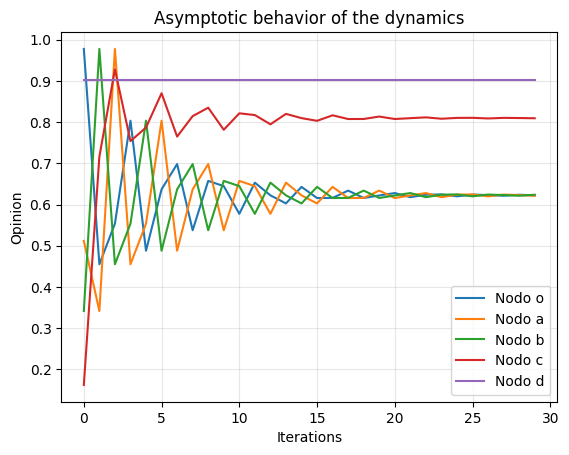

In [12]:
#question g

new_Lambda = np.array([
    [0, 2/5, 1/5, 0, 0],
    [0, 0, 3/4, 0, 0],
    [1/2, 0, 0, 0, 0],
    [0, 0, 1/3, 0, 2/3],
    [0, 0, 0, 0, 1]
])
#the node d is isolated but we add a self loop on it for the computation of the out-degrees (to not divide by 0)

w = new_Lambda.sum(axis=1)

new_P = np.zeros((n, n))
for i in range(n):
    if w[i] > 0:
        new_P[i, :] = new_Lambda[i, :] / w[i]

# save the evolution of the consensus
new_x = np.zeros((n,steps))

# random initial conditions
new_x[:,0] = np.random.rand(5)

# evolve the states
for t in range(1,steps):
    new_x[:,t] = new_P @ new_x[:,t-1]
    
new_x[:,steps-1]

print("The asymptotic state is:", new_x[:,steps-1])

for i in range(n):
    plt.plot(new_x[i,:], label=f'Nodo {nodes[i]}')

plt.title('Asymptotic behavior of the dynamics')
plt.xlabel('Iterations')
plt.ylabel('Opinion')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Invariant distribution π: [0.    0.    0.167 0.5   0.333]
The consensus state is: [0.554 0.598 0.466 0.642 0.466]
The consensus value is: 0.5542455756290177


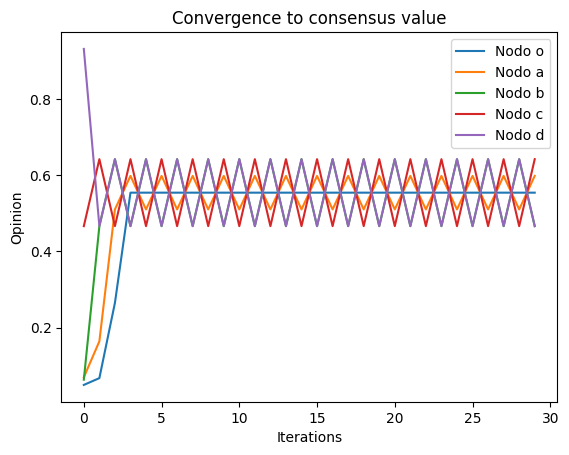

In [13]:
#question h

Lambda_1 = np.array([
    [0, 2/5, 1/5, 0, 0],
    [0, 0, 3/4, 1/4, 0],
    [0, 0, 0, 1/3, 0],
    [0, 0, 1/3, 0, 2/3],
    [0, 0, 0, 1/3, 0]
])

w_1 = Lambda_1.sum(axis=1)
P_1 = np.zeros_like(Lambda_1)

for i in range(n):
    if w_1[i] > 0:
        P_1[i, :] = Lambda_1[i, :] / w_1[i]

# Finding the invariant distribution: it is unique because there is one sink component and the nodes that do not belong to this component have the distribution equal to 0
vals, vecs = np.linalg.eig(P_1.T)
pi_1 = vecs[:, np.isclose(vals, 1)].real.flatten()
pi_1 = pi_1 / np.sum(pi_1)

print("Invariant distribution π:", pi_1)
# Simulation
x_1 = np.zeros((n, steps))
#Arbitrary initial conditions
x_1[:,0] = np.random.rand(5) 

for t in range(1, steps):
    x_1[:,t] = P_1 @ x_1[:,t-1]

print("The consensus state is:", x_1[:,steps-1])
print("The consensus value is:", pi_1 @ x_1[:,0])
# Plotting the asymptotic behavior
for i in range(n):
    plt.plot(x_1[i,:], label=f'Nodo {nodes[i]}')

plt.title('Convergence to consensus value')
plt.xlabel('Iterations')
plt.ylabel('Opinion')
plt.legend()
plt.show()

# HW2 - ex 2 

### **A)** If N = 100 particles all start in node a, what is the average time for a particle to return to node a? 

In [14]:
n_particles = 100 

ERT_particles = np.zeros(n_particles)

for i in range(n_particles):
    for j in range(n_sim):
        _, ret_time, _ = simulate_ctmc(start_node=1, target_return_node=1, max_steps=1000)
        if ret_time is not None:
            ERT_particles[i] += ret_time

ERT_particles /= n_sim
ERT_average = np.mean(ERT_particles)

print(f"Average Return Time (N={n_particles} particles): {ERT_average} t.u.")

Average Return Time (N=100 particles): 6.701679500536474 t.u.


#### How does this compare to the answer in Problem 1, why?

In [15]:
print('Error simulating one single particle:', abs(avg_return_sim - E_return_theoretical))
print('Error simulating multiple particles:', abs(ERT_average - E_return_theoretical))

Error simulating one single particle: 0.13237544475913854
Error simulating multiple particles: 0.006653832796861714


### **B)** If N = 100 particles start in node a, and the system is simulated for 60 time units, what is the average number of particles in the different nodes at the end of the simulation?

The mathematical definition of the rates and probabilities in the Node Perspective (Gillespie Algorithm) are:

$$
\text{Individual Event Rate:} \quad \lambda_i(t) = \omega_i N_i(t)
$$

$$
\text{Total Event Rate:} \quad R_{\text{total}}(t) = \sum_{j} \lambda_j(t) = \sum_{j} \omega_j N_j(t)
$$

$$
\text{Time to Next Event (Minimum of Exponentials Theorem):} \quad t_{\text{next}} \sim \text{Exp}(R_{\text{total}})
$$

$$
\text{Departure Probability Rule:} \quad P(\text{Node } i \text{ departs}) = \frac{\lambda_i(t)}{R_{\text{total}}(t)}
$$

In [16]:
final__average = np.zeros(n, dtype=float)
n_sim = 1000 # Example number of runs

history = {i : np.array([[100, 0, 0, 0, 0 ]], dtype=float) for i in range(n_sim)} # to store the history of each simulation
time_units = 60 
for i in range(n_sim):

    n_nodes_t = np.zeros(n, dtype=float)
    n_nodes_t[0] = 100   # initial particles in node 'o'
    transition_times = [0] # reset the clock time
    
    λ = n_nodes_t * ω   # rate of losing the next particle from node i    
    R_t = np.sum(λ) 
    P_nodes = λ / R_t #  probability that the next particle to leave comes from node i (we begin at [1,0,0,0,0] because all the particles are in 'o') 
    t_next = -np.log(np.random.rand())/R_t  # time to the NEXT EVENT (losing the next particle from the system)
    
    # NOTE : R_t is the total rate of losing the next particle from the system.
    # ( rate of the single, equivalent clock (min(T0,T1, ... )) that governs when the next event happens anywhere in the network) 
    
    timeSeq = []
    timeSeq.append(0)
    
    while transition_times[-1] < time_units:
        
        next_time = transition_times[-1] + t_next
        transition_times.append(next_time)
        #if the new event would happen after time_units, we stop the simulation
        if next_time >= time_units:
            break
        
        timeSeq.append(transition_times[-1])
        
        departure_node_i = np.random.choice(n, p=P_nodes) #which node i will lose a particle ? 
        destination_node_j = np.random.choice(n, p=P[departure_node_i, :])  # to which node j this particle will go ? 

        n_nodes_t[departure_node_i] -= 1  
        n_nodes_t[destination_node_j] += 1  
        history[i] = np.concatenate((history[i], [n_nodes_t]), axis=0) 

        # recompute the rates : each particle has his own Poisson clock 
        λ = n_nodes_t * ω
        R_t = np.sum(λ) 
        
        if R_t == 0:
            break
            
        P_nodes = λ / R_t 
        t_next = -np.log(np.random.rand())/R_t
        

    final__average += n_nodes_t.copy() 
    
    
final__average /= n_sim
print(f"Average number of particles in each node after {time_units} time units: {final__average}")
    

Average number of particles in each node after 60 time units: [21.767 15.079 26.08  18.742 18.332]


The Ergodic Theorem guarantees that, for a strongly connected (irreducible) continuous-time Markov chain like the one we are simulating, the long-term behavior of the system will match the theoretical stationary distribution $$\bar{\pi} = [0.217, 0.149, 0.261, 0.186, 0.186]$$

#### Illustrate the simulation above with a plot showing the number of particles in each node during the simulation time.

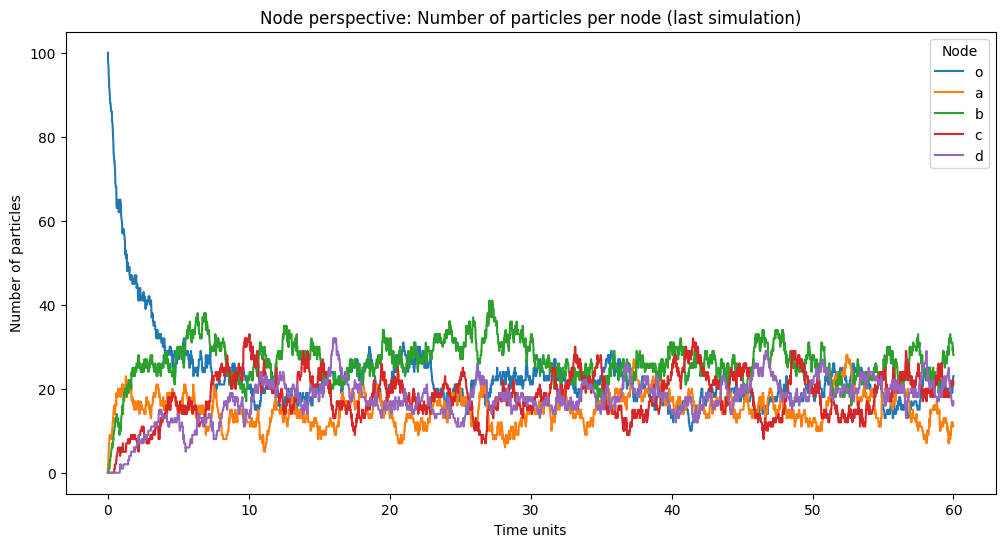

In [17]:
plt.figure(figsize=(12, 6))

run_index = n_sim - 1  #plotting the last simulation
count_history_for_run = history[run_index] 
labels = dict(enumerate(G.nodes))

for node in range(n):
    node_evolution = count_history_for_run[:, node]
    plt.plot(timeSeq, node_evolution, label=labels[node])
    
plt.legend(title='Node')
plt.title("Node perspective: Number of particles per node (last simulation)")
plt.xlabel('Time units')
plt.ylabel('Number of particles')
plt.savefig("Ex2_B.pdf")
plt.show()

# HW2 - ex 3

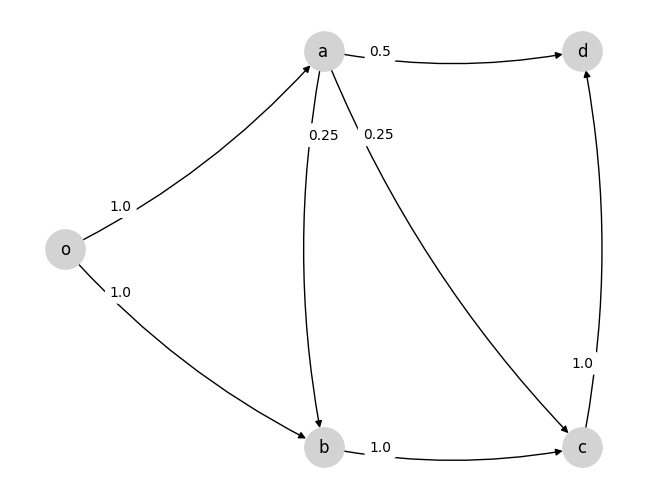

In [18]:
Λ = np.array([
        [0, 1, 1, 0, 0],             # o → a, o → b
        [0, 0, 1/4, 1/4, 1/2],     # a → b, a → c, a → d  
        [0, 0, 0, 1, 0],             # b → c
        [0, 0, 0, 0, 1],             # c → d
        [0, 0, 0, 0, 0]              # d → ∅
    ])

G = nx.DiGraph()
G.add_nodes_from(['o','a','b','c','d'])
G.add_weighted_edges_from([('o', 'a', float("{0:.2f}".format(1))), 
                           ('o', 'b', float("{0:.2f}".format(1))),
                           ('a', 'b', float("{0:.2f}".format(1/4))), 
                           ('a', 'c', float("{0:.2f}".format(1/4))),
                           ('a', 'd', float("{0:.2f}".format(2/4))), 
                           ('b', 'c', float("{0:.2f}".format(1))), 
                           ('c', 'd', float("{0:.2f}".format(1)))])
                   
pos={'o':(0,0),'a':(1,2),'b':(1,-2),'c':(2,-2),'d':(2,2)}
nx.draw(G, pos=pos, with_labels=True, node_size = 800, font_size=12, node_color='lightgray',  connectionstyle='arc3, rad = 0.1')
labels = {e: G.edges[e]['weight'] for e in G.edges}
val = nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.20, rotate = False, horizontalalignment ='center')

In [19]:
n = len(G.nodes)

ω = np.sum(Λ, axis=1)
ω[-1] = 7/4 #since node d does not have a node to send its particles to, we assume that ω_d = 7/4
ω_star = np.max(ω)

D = np.diag(ω) 
P = np.linalg.inv(D) @ Λ

In [20]:
P

array([[0.  , 0.5 , 0.5 , 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.25, 0.5 ],
       [0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ]])

In [21]:
ω

array([2.  , 1.  , 1.  , 1.  , 1.75])

### **A)** Proportional Rate  
#### Simulate the system for 60 time units and plot the evolution of the number of particles in each node over time with input rate $\lambda = 100$.  
The rate of the Poisson clock at each node is proportional to the number of particles in that node.

Since the particle count Ni​(t) changes over time, making the internal movement rates dynamic, the simulation uses the Gillespie First Reaction Method (FRM), a highly accurate technique for continuous-time Markov processes. 

We identify all rates : 
$$
    R = \begin{pmatrix}
    \lambda, & \omega_o N_o, & \omega_a N_a, & \omega_b N_b, & \omega_c N_c, & \omega_d N_d
    \end{pmatrix}
$$

Then calculate All Times-to-Event $(Tk​)$:
$$
    T_k = \frac{-\ln(u_k)}{R_k} \quad \text{where } u_k \sim \mathcal{U}(0,1)
$$

And finally, execute the fastest event $t_{\text{next}} = \min(T_k)$.




In [22]:
time_units = 60
history = np.array([[0, 0, 0, 0, 0 ]]) # the particles this time will come from outside the system

transition_times = [0]

n_nodes_t = np.zeros(n, dtype=float)
λ_in = 100   # input system rate of particles in node 'o' (all the particles enter from outside the system into node 'o')

R_t = [λ_in, 
       n_nodes_t[0] * ω[0], 
       n_nodes_t[1] * ω[1], 
       n_nodes_t[2] * ω[2], 
       n_nodes_t[3] * ω[3], 
       n_nodes_t[4] * ω[4]]

t_next_k = [-np.log(np.random.rand())/(rate + 1e-8) for rate in R_t] # time to the NEXT EVENT (losing the next particle from the system or a particle entering the system)
# NOTE : since some rates can be zero (if there are no particles in a given node), we add a small value 1e-8 to avoid division by zero
t_next = np.min(t_next_k)

timeSeq = []
timeSeq.append(0)
    
while transition_times[-1] < time_units:  
    
    next_time = transition_times[-1] + t_next
    transition_times.append(next_time)
    #if the new event would happen after time_units, we stop the simulation
    if next_time >= time_units:
            break
        
    timeSeq.append(transition_times[-1])
    k_event = np.argmin(t_next_k)  # which event happens next ? (k=0 means a particle enters the system, k=1 means a particle leaves from node 'o', k=2 from node 'a', etc.)

    if k_event == 0:
        n_nodes_t[0] += 1

    else:
    # the departure node index is k_event - 1 (since k=1 maps to node 0, k=2 to node 1, etc.)
        departure_node_i = k_event - 1
    
        if n_nodes_t[departure_node_i] > 0:
            n_nodes_t[departure_node_i] -= 1
            if departure_node_i == n - 1:
            # particle leaves the system from node 'd'
                pass
            else:
                destination_node_j = np.random.choice(n, p=P[departure_node_i, :])
                n_nodes_t[destination_node_j] += 1

    history = np.concatenate((history, [n_nodes_t.copy()]), axis=0)
    
#recompute the rates :
    R_t = [λ_in, 
    n_nodes_t[0] * ω[0], 
    n_nodes_t[1] * ω[1], 
    n_nodes_t[2] * ω[2], 
    n_nodes_t[3] * ω[3], 
    n_nodes_t[4] * ω[4]]
    
    t_next_k = [-np.log(np.random.rand())/(rate + 1e-8) for rate in R_t] 
    t_next = np.min(t_next_k)


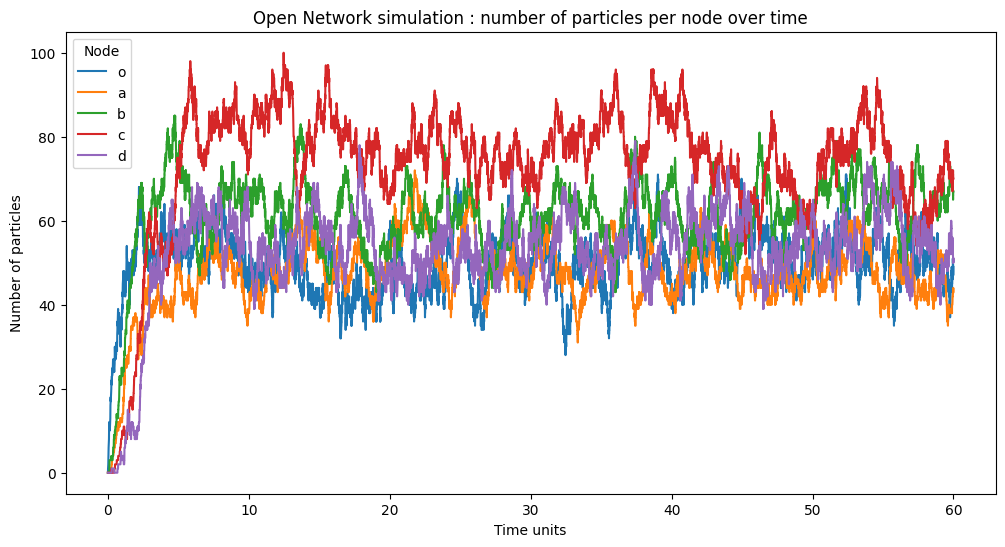

In [23]:
plt.figure(figsize=(12, 6))

count_history_for_run = history 
labels = dict(enumerate(G.nodes))

for node in range(n):
    node_evolution = count_history_for_run[:, node]
    plt.plot(timeSeq, node_evolution, label=labels[node])
    
plt.legend(title='Node')
plt.title("Open Network simulation : number of particles per node over time")
plt.xlabel('Time units')
plt.ylabel('Number of particles')
plt.savefig("Ex2_B.pdf")
plt.show()

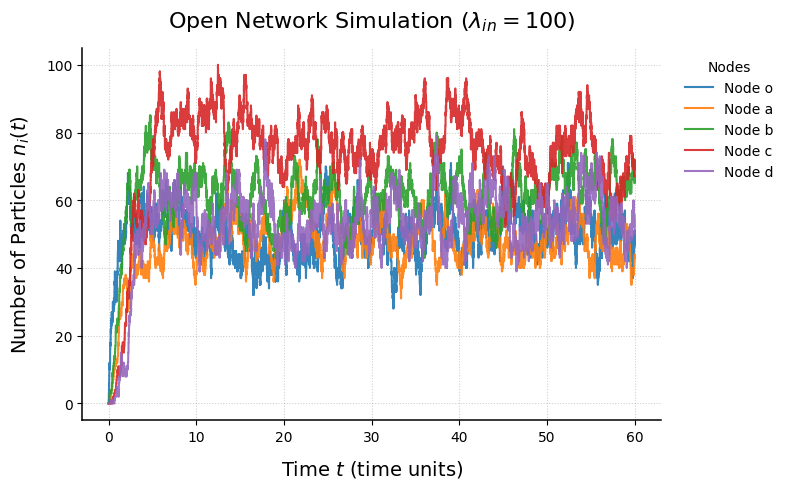

In [24]:
# --- 4. Plotting (The requested part) ---
fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.tab10.colors 

for i in range(n):
    # Use 'step' with 'post' for scientifically accurate jump process visualization
    ax.step(
        timeSeq, 
        history[:, i], 
        where='post',
        label=f'Node {nodes[i]}', 
        color=colors[i % len(colors)],
        linewidth=1.5,
        alpha=0.9
    )

# Aesthetics
ax.set_xlabel(r'Time $t$ (time units)', fontsize=14, labelpad=10)
ax.set_ylabel(r'Number of Particles $n_i(t)$', fontsize=14, labelpad=10)
ax.set_title(r'Open Network Simulation ($\lambda_{in}=100$)', fontsize=16, pad=15)

ax.grid(which='major', linestyle=':', linewidth=0.75, color='gray', alpha=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.1)
ax.spines['bottom'].set_linewidth(1.1)

legend = ax.legend(frameon=True, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10, title="Nodes")
legend.get_frame().set_edgecolor('none')

plt.tight_layout()
plt.savefig('Ex3_A_SOTA.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### What is the largest input rate that the system can handle without blowing up?

let's for the sake of curiosity increase the input rate as $\lambda_{high} = 10\lambda$

In [25]:
time_units = 60
history = np.array([[0, 0, 0, 0, 0 ]]) # the particles this time will come from outside the system

transition_times = [0]

n_nodes_t = np.zeros(n, dtype=float)
λ_high = 10 * λ_in   # input system rate of particles in node 'o' (all the particles enter from outside the system into node 'o')

R_t = [λ_high, 
       n_nodes_t[0] * ω[0], 
       n_nodes_t[1] * ω[1], 
       n_nodes_t[2] * ω[2], 
       n_nodes_t[3] * ω[3], 
       n_nodes_t[4] * ω[4]]

t_next_k = [-np.log(np.random.rand())/(rate + 1e-8) for rate in R_t] # time to the NEXT EVENT (losing the next particle from the system or a particle entering the system)
# NOTE : since some rates can be zero (if there are no particles in a given node), we add a small value 1e-8 to avoid division by zero
t_next = np.min(t_next_k)

timeSeq = []
timeSeq.append(0)
    
while transition_times[-1] < time_units:  
    
    next_time = transition_times[-1] + t_next
    transition_times.append(next_time)
    #if the new event would happen after time_units, we stop the simulation
    if next_time >= time_units:
            break
        
    timeSeq.append(transition_times[-1])
    k_event = np.argmin(t_next_k)  # which event happens next ? (k=0 means a particle enters the system, k=1 means a particle leaves from node 'o', k=2 from node 'a', etc.)

    if k_event == 0:
        n_nodes_t[0] += 1

    else:
    # the departure node index is k_event - 1 (since k=1 maps to node 0, k=2 to node 1, etc.)
        departure_node_i = k_event - 1
    
        if n_nodes_t[departure_node_i] > 0:
            n_nodes_t[departure_node_i] -= 1
            if departure_node_i == n - 1:
            # particle leaves the system from node 'd'
                pass
            else:
                destination_node_j = np.random.choice(n, p=P[departure_node_i, :])
                n_nodes_t[destination_node_j] += 1

    history = np.concatenate((history, [n_nodes_t.copy()]), axis=0)
    
#recompute the rates :
    R_t = [λ_high, 
    n_nodes_t[0] * ω[0], 
    n_nodes_t[1] * ω[1], 
    n_nodes_t[2] * ω[2], 
    n_nodes_t[3] * ω[3], 
    n_nodes_t[4] * ω[4]]
    
    t_next_k = [-np.log(np.random.rand())/(rate + 1e-8) for rate in R_t] 
    t_next = np.min(t_next_k)

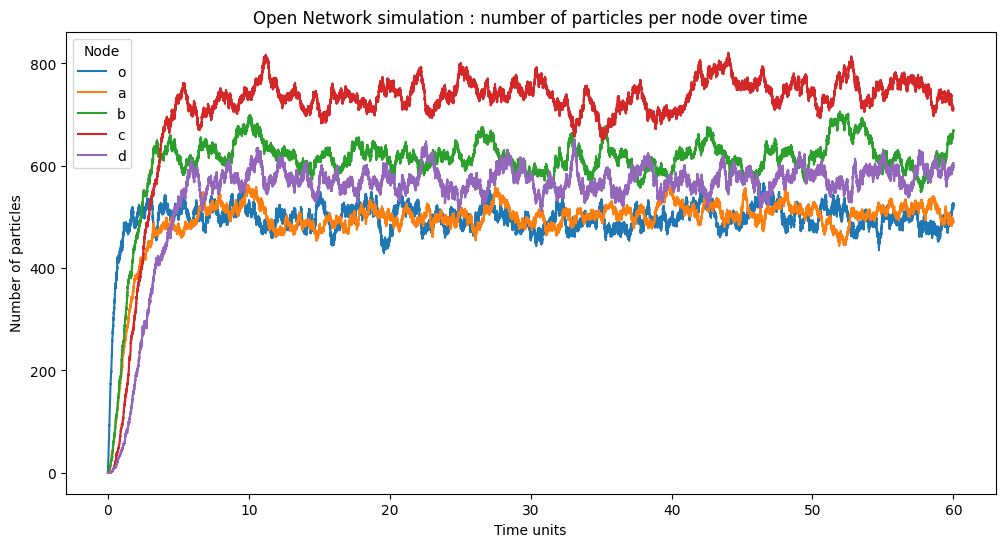

In [26]:
plt.figure(figsize=(12, 6))

count_history_for_run = history 
labels = dict(enumerate(G.nodes))

for node in range(n):
    node_evolution = count_history_for_run[:, node]
    plt.plot(timeSeq, node_evolution, label=labels[node])
    
plt.legend(title='Node')
plt.title("Open Network simulation : number of particles per node over time")
plt.xlabel('Time units')
plt.ylabel('Number of particles')
plt.savefig("Ex2_B.pdf")
plt.show()

The system still remains stable, we just had way more computational efforts.
Does exist a way to prove a breaking point ? 
We did it on the report!

### **B)** Fixed Rate  
#### Simulate the system for 6000 time units and plot the evolution of number of particles in each node over time with input rate $λ = 2$.  
The rate of the Poisson clock at each node is equal to the number of particles in that node.

In [27]:
time_units = 6000
history = np.array([[0, 0, 0, 0, 0 ]]) # the particles this time will come from outside the system

transition_times = [0]

n_nodes_t = np.zeros(n, dtype=float)
λ_in = 2  # input system rate of particles in node 'o' (all the particles enter from outside the system into node 'o')

# NOTE : we cannot send particles from empty nodes, so
# we calculate a masked version of ω to avoid having rates for nodes with zero particles!!!!!!!!
ω_mask = [
    ω[i] if n_nodes_t[i] > 0 else 0.0
    for i in range(n) 
]

R_t = [λ_in, 
       ω_mask[0],
       ω_mask[1], 
       ω_mask[2], 
       ω_mask[3], 
       ω_mask[4]]


t_next_k = [-np.log(np.random.rand())/(rate + 1e-8) for rate in R_t] # time to the NEXT EVENT (losing the next particle from the system or a particle entering the system)
# NOTE : since some rates can be zero (if there are no particles in a given node), we add a small value 1e-8 to avoid division by zero
t_next = np.min(t_next_k)

timeSeq = []
timeSeq.append(0)
    
while transition_times[-1] < time_units:  
    
    next_time = transition_times[-1] + t_next
    transition_times.append(next_time)
    #if the new event would happen after time_units, we stop the simulation
    if next_time >= time_units:
            break
        
    timeSeq.append(transition_times[-1])
    k_event = np.argmin(t_next_k)  # which event happens next ? (k=0 means a particle enters the system, k=1 means a particle leaves from node 'o', k=2 from node 'a', etc.)

    if k_event == 0:
        n_nodes_t[0] += 1

    else:
    # the departure node index is k_event - 1 (since k=1 maps to node 0, k=2 to node 1, etc.)
        departure_node_i = k_event - 1
    
        if n_nodes_t[departure_node_i] > 0:
            n_nodes_t[departure_node_i] -= 1
            if departure_node_i == n - 1:
            # particle leaves the system from node 'd'
                pass
            else:
                destination_node_j = np.random.choice(n, p=P[departure_node_i, :])
                n_nodes_t[destination_node_j] += 1

    history = np.concatenate((history, [n_nodes_t.copy()]), axis=0)
    
    ω_mask = [
    ω[i] if n_nodes_t[i] > 0 else 0.0
    for i in range(n)
    ]
    
    R_t = [λ_in, 
       ω_mask[0],
       ω_mask[1], 
       ω_mask[2],       
       ω_mask[3], 
       ω_mask[4]]
    
    t_next_k = [-np.log(np.random.rand())/(rate + 1e-8) for rate in R_t] 
    t_next = np.min(t_next_k)

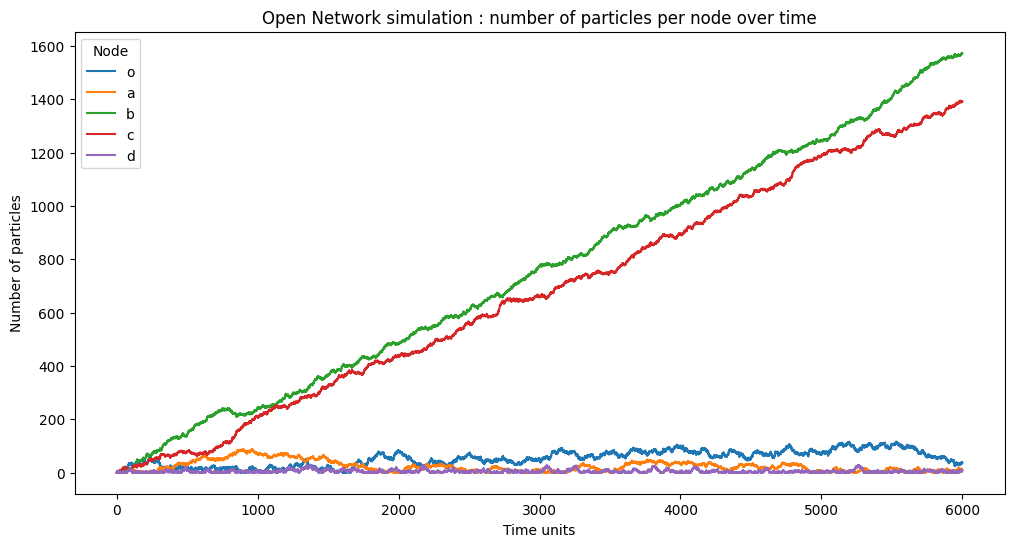

In [28]:
plt.figure(figsize=(12, 6))

count_history_for_run = history 
labels = dict(enumerate(G.nodes))
                                
for node in range(n):
    node_evolution = count_history_for_run[:, node]
    plt.plot(timeSeq, node_evolution, label=labels[node])
    
plt.legend(title='Node')
plt.title("Open Network simulation : number of particles per node over time")
plt.xlabel('Time units')
plt.ylabel('Number of particles')
plt.savefig("Ex2_B.pdf")
plt.show()

#### What is the largest input rate that the system can handle without blowing up? Motivate your answer.

In [29]:
λ_in = 2
r = np.array([λ_in, 0, 0, 0, 0])

#  Traffic Equations: lambda = r(I - P)^-1
#  derived from lambda = r + lambda*P
I = np.eye(5)
inv_matrix = np.linalg.inv(I - P)
λ = np.dot(r, inv_matrix)

print("Theoretical Arrival Rates (λ):", λ)

Theoretical Arrival Rates (λ): [2.   1.   1.25 1.5  2.  ]


In [30]:
ρ = λ / ω

print(f"Node Utilizations (ρ): {ρ}")

bottleneck_idx = np.argmax(ρ)
max_rho = ρ[bottleneck_idx]

print(f"Bottleneck Node: '{nodes[bottleneck_idx]}' with utilization {max_rho:.2f}")

λ_system_limit = λ_in / max_rho

print("-" * 30)
print(f"RESULTS:")
print(f"Current Input: {λ_in}")
print(f"Theoretical Max Input (Capacity): {λ_system_limit:.4f}")

Node Utilizations (ρ): [1.    1.    1.25  1.5   1.143]
Bottleneck Node: 'c' with utilization 1.50
------------------------------
RESULTS:
Current Input: 2
Theoretical Max Input (Capacity): 1.3333


let's see if it is true.. what if $\lambda_{in} = 1.4 > 1.3333 = \lambda_{max}$ ???

In [31]:
time_units = 600
history = np.array([[0, 0, 0, 0, 0 ]]) # the particles this time will come from outside the system

transition_times = [0]

n_nodes_t = np.zeros(n, dtype=float)
λ_in = 1.4  # input system rate of particles in node 'o' (all the particles enter from outside the system into node 'o')

# NOTE : we cannot send particles from empty nodes, so
# we calculate a masked version of ω to avoid having rates for nodes with zero particles!!!!!!!!
ω_mask = [
    ω[i] if n_nodes_t[i] > 0 else 0.0
    for i in range(n) 
]

R_t = [λ_in, 
       ω_mask[0],
       ω_mask[1], 
       ω_mask[2], 
       ω_mask[3], 
       ω_mask[4]]


t_next_k = [-np.log(np.random.rand())/(rate + 1e-8) for rate in R_t] # time to the NEXT EVENT (losing the next particle from the system or a particle entering the system)
# NOTE : since some rates can be zero (if there are no particles in a given node), we add a small value 1e-8 to avoid division by zero
t_next = np.min(t_next_k)

timeSeq = []
timeSeq.append(0)
    
while transition_times[-1] < time_units:  
    
    next_time = transition_times[-1] + t_next
    transition_times.append(next_time)
    #if the new event would happen after time_units, we stop the simulation
    if next_time >= time_units:
            break
        
    timeSeq.append(transition_times[-1])
    k_event = np.argmin(t_next_k)  # which event happens next ? (k=0 means a particle enters the system, k=1 means a particle leaves from node 'o', k=2 from node 'a', etc.)

    if k_event == 0:
        n_nodes_t[0] += 1

    else:
    # the departure node index is k_event - 1 (since k=1 maps to node 0, k=2 to node 1, etc.)
        departure_node_i = k_event - 1
    
        if n_nodes_t[departure_node_i] > 0:
            n_nodes_t[departure_node_i] -= 1
            if departure_node_i == n - 1:
            # particle leaves the system from node 'd'
                pass
            else:
                destination_node_j = np.random.choice(n, p=P[departure_node_i, :])
                n_nodes_t[destination_node_j] += 1

    history = np.concatenate((history, [n_nodes_t.copy()]), axis=0)
    
    ω_mask = [
    ω[i] if n_nodes_t[i] > 0 else 0.0
    for i in range(n)
    ]
    
    R_t = [λ_in, 
       ω_mask[0],
       ω_mask[1], 
       ω_mask[2],       
       ω_mask[3], 
       ω_mask[4]]
    
    t_next_k = [-np.log(np.random.rand())/(rate + 1e-8) for rate in R_t] 
    t_next = np.min(t_next_k)

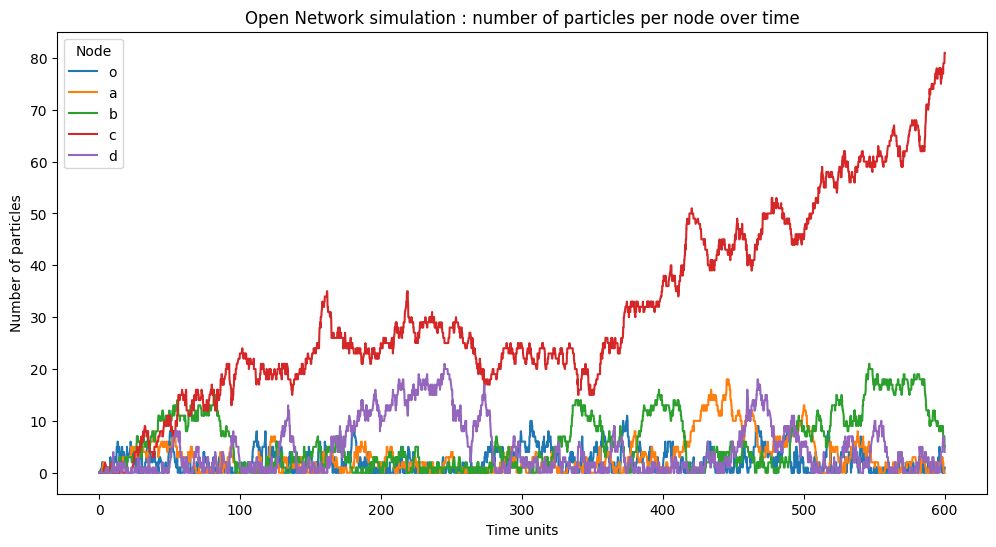

In [32]:
plt.figure(figsize=(12, 6))

count_history_for_run = history 
labels = dict(enumerate(G.nodes))
                                
for node in range(n):
    node_evolution = count_history_for_run[:, node]
    plt.plot(timeSeq, node_evolution, label=labels[node])
    
plt.legend(title='Node')
plt.title("Open Network simulation : number of particles per node over time")
plt.xlabel('Time units')
plt.ylabel('Number of particles')
plt.savefig("Ex2_B.pdf")
plt.show()

IT BLOWS UP!
what about $\lambda_{in} = 1.2 < 1.3333 = \lambda_{max}$  ? 

In [33]:
time_units = 600
history = np.array([[0, 0, 0, 0, 0 ]]) # the particles this time will come from outside the system

transition_times = [0]

n_nodes_t = np.zeros(n, dtype=float)
λ_in = 1.2  # input system rate of particles in node 'o' (all the particles enter from outside the system into node 'o')

# NOTE : we cannot send particles from empty nodes, so
# we calculate a masked version of ω to avoid having rates for nodes with zero particles!!!!!!!!
ω_mask = [
    ω[i] if n_nodes_t[i] > 0 else 0.0
    for i in range(n) 
]

R_t = [λ_in, 
       ω_mask[0],
       ω_mask[1], 
       ω_mask[2], 
       ω_mask[3], 
       ω_mask[4]]


t_next_k = [-np.log(np.random.rand())/(rate + 1e-8) for rate in R_t] # time to the NEXT EVENT (losing the next particle from the system or a particle entering the system)
# NOTE : since some rates can be zero (if there are no particles in a given node), we add a small value 1e-8 to avoid division by zero
t_next = np.min(t_next_k)

timeSeq = []
timeSeq.append(0)
    
while transition_times[-1] < time_units:  
    
    next_time = transition_times[-1] + t_next
    transition_times.append(next_time)
    #if the new event would happen after time_units, we stop the simulation
    if next_time >= time_units:
            break
        
    timeSeq.append(transition_times[-1])
    k_event = np.argmin(t_next_k)  # which event happens next ? (k=0 means a particle enters the system, k=1 means a particle leaves from node 'o', k=2 from node 'a', etc.)

    if k_event == 0:
        n_nodes_t[0] += 1

    else:
    # the departure node index is k_event - 1 (since k=1 maps to node 0, k=2 to node 1, etc.)
        departure_node_i = k_event - 1
    
        if n_nodes_t[departure_node_i] > 0:
            n_nodes_t[departure_node_i] -= 1
            if departure_node_i == n - 1:
            # particle leaves the system from node 'd'
                pass
            else:
                destination_node_j = np.random.choice(n, p=P[departure_node_i, :])
                n_nodes_t[destination_node_j] += 1

    history = np.concatenate((history, [n_nodes_t.copy()]), axis=0)
    
    ω_mask = [
    ω[i] if n_nodes_t[i] > 0 else 0.0
    for i in range(n)
    ]
    
    R_t = [λ_in, 
       ω_mask[0],
       ω_mask[1], 
       ω_mask[2],       
       ω_mask[3], 
       ω_mask[4]]
    
    t_next_k = [-np.log(np.random.rand())/(rate + 1e-8) for rate in R_t] 
    t_next = np.min(t_next_k)

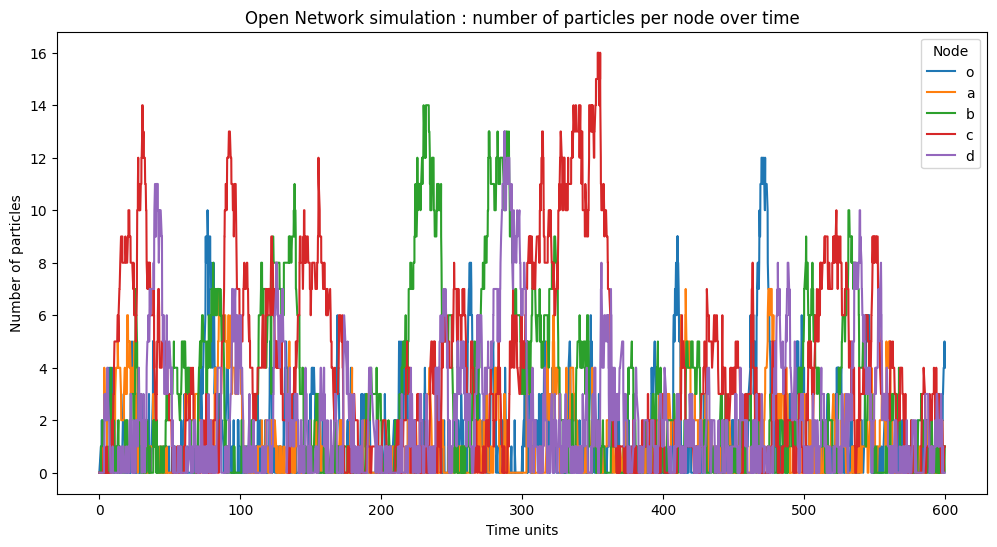

In [34]:
plt.figure(figsize=(12, 6))

count_history_for_run = history 
labels = dict(enumerate(G.nodes))
                                
for node in range(n):
    node_evolution = count_history_for_run[:, node]
    plt.plot(timeSeq, node_evolution, label=labels[node])
    
plt.legend(title='Node')
plt.title("Open Network simulation : number of particles per node over time")
plt.xlabel('Time units')
plt.ylabel('Number of particles')
plt.savefig("Ex2_B.pdf")
plt.show()

It does not! This confirms our computations.